In [1]:
import os
os.chdir("../")

In [2]:
import json
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import supervision as sv
from sklearn import metrics
plt.rc('font', family="Arial")

from groundingdino.util.inference import load_model, load_image, predict, annotate
import groundingdino.datasets.transforms as T
import tensorflow as tf
from xplique.attributions import (Rise, KernelShap, HsicAttributionMethod)
from xplique.wrappers import TorchWrapper
from xplique.plots import plot_attributions

from torchvision.ops import box_convert
from utils import COCO_TEXT_PROMPT, coco_classes, coco_classes_grounding_idx, mkdir

2024-10-10 01:25:51.821493: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 01:25:51.861056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 01:25:51.861100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 01:25:51.862196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 01:25:51.868435: I tensorflow/core/platform/cpu_feature_guar

In [3]:
tf.config.run_functions_eagerly(True)

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048*5)]
)

In [4]:
data_transform = T.Compose(
    [
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


In [5]:
def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."

def transform_vision_data(image):
    """
    Input:
        image: An image read by opencv [w,h,c]
    Output:
        image: After preproccessing, is a tensor [c,w,h]
    """
    image = Image.fromarray(image)
    image_transformed, _ = data_transform(image, None)
    return image_transformed

In [6]:
class GroundingDino_Adaptation_Xplique(torch.nn.Module):
    def __init__(self, 
                 detection_model,
                 device = "cuda"):
        super().__init__()
        self.detection_model = detection_model
        self.device = device
        self.detection_model.to(self.device)
        
        self.caption = None
        
        self.h = None
        self.k = None
        
        self.batch_size = 16
        
        self.target_box = None
        self.target_label = None
    
    def calculate_iou(self, batched_boxes, target_box):
        # batched_boxes: [batch, np, 4]
        # target_box: [4]

        # Separation coordinates
        x1, y1, x2, y2 = batched_boxes[..., 0], batched_boxes[..., 1], batched_boxes[..., 2], batched_boxes[..., 3]
        tx1, ty1, tx2, ty2 = torch.tensor(target_box)

        # Calculate intersection area
        inter_x1 = torch.maximum(x1, tx1)
        inter_y1 = torch.maximum(y1, ty1)
        inter_x2 = torch.minimum(x2, tx2)
        inter_y2 = torch.minimum(y2, ty2)

        # 计算相交区域的面积
        inter_area = torch.clamp((inter_x2 - inter_x1), min=0) * torch.clamp((inter_y2 - inter_y1), min=0)

        # Calculate the area of ​​the intersection
        box_area = (x2 - x1) * (y2 - y1)
        target_area = (tx2 - tx1) * (ty2 - ty1)

        # Calculating IoU
        union_area = box_area + target_area - inter_area
        iou = inter_area / union_area

        return iou
    
    def process_in_batches(self, images):
        all_bounding_boxes = []
        all_logits = []

        # 将输入图像拆分为 batch_size 批次
        num_batches = (len(images) + self.batch_size - 1) // self.batch_size  # 计算需要的批次数

        for i in range(num_batches):
            # 获取当前批次的图像
            batch_images = images[i * self.batch_size:(i + 1) * self.batch_size]

            # 将当前批次传递到检测模型
            bounding_boxes, logits = self.forward_results(batch_images)

            # 将结果收集到列表中
            all_bounding_boxes.append(bounding_boxes)
            all_logits.append(logits)

        # 将所有批次的结果拼接成一个完整的张量
        all_bounding_boxes = torch.cat(all_bounding_boxes, dim=0)
        all_logits = torch.cat(all_logits, dim=0)

        return all_bounding_boxes, all_logits
    
    def forward_results(self, images):
        """_summary_

        Args:
            images (tensor): torch.Size([batch, 3, 773, 1332])
        """
        batch = images.shape[0]
        captions = [self.caption for i in range(batch)]
        
        with torch.no_grad():
            outputs = self.detection_model(images, captions=captions)
            
        prediction_logits = outputs["pred_logits"].cpu().sigmoid()  # prediction_logits.shape = (batch, nq, 256)
        prediction_boxes = outputs["pred_boxes"].cpu()  # prediction_boxes.shape = (batch, nq, 4)

        boxes = prediction_boxes * torch.Tensor([self.w, self.h, self.w, self.h])
        xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")
        
        return xyxy, prediction_logits
    
    def forward(self, images):
        # images (100, 773, 1332, 3)
        batch_input_images = images.to(self.device)
        
        with torch.no_grad():
            bounding_boxes, logits = self.forward_results(batch_input_images) # [batch, np, 4] [batch, np, 256]
        
        ious = self.calculate_iou(bounding_boxes, self.target_box)
        cls_score = logits[:,:,torch.tensor(self.target_label)].max(dim=-1)[0]
        
        scores = (ious * cls_score).max(dim=-1, keepdim=True)[0]
        
        del bounding_boxes
        del logits
        del ious
        del cls_score
        
        return scores

In [7]:
# input
image_path = "datasets/coco/val2017/000000090003.jpg"
image = cv2.imread(image_path)
target_box = [219,213,493,365]
target_class = [38]
TEXT_PROMPT = "person . bicycle . car . motorcycle . airplane . bus . train . truck . boat . traffic light . fire hydrant . stop sign . parking meter . bench . bird . cat . dog . horse . sheep . cow . elephant . bear . zebra . giraffe . backpack . umbrella . handbag . tie . suitcase . frisbee . skis . snowboard . sports ball . kite . baseball bat . baseball glove . skateboard . surfboard . tennis racket . bottle . wine glass . cup . fork . knife . spoon . bowl . banana . apple . sandwich . orange . broccoli . carrot . hot dog . pizza . donut . cake . chair . couch . potted plant . bed . dining table . toilet . tv . laptop . mouse . remote . keyboard . cell phone . microwave . oven . toaster . sink . refrigerator . book . clock . vase . scissors . teddy bear . hair drier . toothbrush ."

In [8]:
# Load the model
model = load_model("config/GroundingDINO_SwinT_OGC.py", "ckpt/groundingdino_swint_ogc.pth")

detection_model = GroundingDino_Adaptation_Xplique(model, device = "cuda")
caption = preprocess_caption(caption=TEXT_PROMPT)
detection_model.caption = caption

final text_encoder_type: bert-base-uncased


In [9]:
detection_model.h, detection_model.w = image.shape[:2]
detection_model.target_box = target_box
detection_model.target_label = target_class

In [10]:
image_proccess = transform_vision_data(image)

In [11]:
detection_model(image_proccess.unsqueeze(0))

tensor([[0.6776]])

# Explaining by Xplique

In [13]:
X = [image]
X_preprocessed = torch.stack([transform_vision_data(x) for x in X])
X_preprocessed4explainer = np.moveaxis(X_preprocessed.numpy(), [1, 2, 3], [3, 1, 2])
label = tf.keras.utils.to_categorical(0, 1)
Y = np.array([label])

In [14]:
# wrap the torch model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
wrapped_model = TorchWrapper(detection_model.eval(), device)

2024-10-10 01:26:31.268401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-10-10 01:26:31.268880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21480 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [15]:
wrapped_model.model.w

640

Method: Rise


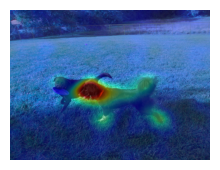



Method: HsicAttributionMethod


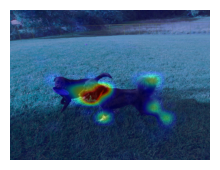

In [17]:
# set batch size parameter
batch_size = 12

# build the explainers
explainers = [
             Rise(wrapped_model, nb_samples=5000, grid_size=16, batch_size=batch_size),
             HsicAttributionMethod(wrapped_model, nb_design=1500, grid_size=16, batch_size=batch_size),
]

for explainer in explainers:

  explanations = explainer(X_preprocessed4explainer, Y)
  X = np.array([cv2.resize(x, (explanations.shape[2], explanations.shape[1])) for x in X])

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")

In [19]:
explanations[0].shape

TensorShape([800, 1066, 1])

In [ ]:
cv2.resize(X[0], (explanations.shape[2], explanations.shape[1]))

In [21]:
image.shape

(480, 640, 3)

In [27]:
z = cv2.resize(explanations[0].numpy(), (image.shape[1], image.shape[0]))

In [30]:
z.shape

(480, 640)

In [29]:
explanations[0].numpy()

array([[[-0.00396473],
        [-0.00386651],
        [-0.00375494],
        ...,
        [-0.00229571],
        [-0.00232176],
        [-0.00234469]],

       [[-0.00394372],
        [-0.00384565],
        [-0.00373425],
        ...,
        [-0.0022913 ],
        [-0.00231731],
        [-0.00234022]],

       [[-0.00392018],
        [-0.00382227],
        [-0.00371106],
        ...,
        [-0.00228635],
        [-0.00231233],
        [-0.00233521]],

       ...,

       [[-0.00616806],
        [-0.00612343],
        [-0.00607273],
        ...,
        [ 0.03368083],
        [ 0.0337035 ],
        [ 0.03372346]],

       [[-0.00619892],
        [-0.0061542 ],
        [-0.00610342],
        ...,
        [ 0.03371898],
        [ 0.03374171],
        [ 0.03376171]],

       [[-0.00622645],
        [-0.00618167],
        [-0.00613081],
        ...,
        [ 0.03375303],
        [ 0.0337758 ],
        [ 0.03379584]]], dtype=float32)